In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Dataloader creation

In [2]:
# Define custom dataset class for FER2013
class TensorFromDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data.iloc[idx, 1]
        pixels = [int(pixel) for pixel in img_name.split(' ')]
        image = torch.tensor(pixels, dtype=torch.float32).reshape(48, 48)

        label = int(self.data.iloc[idx, 0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# # Define transformations for preprocessing
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((64, 64)),  # Resize the images to match model input size
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])
# transform = None
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

df = pd.read_csv('fer2013/fer2013/fer2013.csv')
training = df[df['Usage'] == 'Training']
validation = df[df['Usage'] == 'PublicTest']
testing = df[df['Usage'] == 'PrivateTest']

# Load FER2013 dataset

train_set = TensorFromDataset(data = training, transform=transform)
valid_set = TensorFromDataset(data = validation, transform=transform)
test_set = TensorFromDataset(data = testing, transform=transform)


# Create data loaders
batch_size = 32
data_loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
data_loader_validation = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [3]:
def split_dataset(loader):
    # Create a DataLoader for the dataset
    # loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize lists to store the features and labels
    features = []
    labels = []

    # Iterate through the DataLoader
    for imgs, lbls in loader:
        # Depending on your model, you might want to move your tensors to a device like CUDA
        imgs, lbls = imgs.cuda(), lbls.cuda()
        
        # Append the batch to the lists
        features.append(imgs)
        labels.append(lbls)

    # Concatenate all batches
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    

    return features, labels

In [4]:
# Splitting of the test_set
X_test, Y_test = split_dataset(data_loader_test)

In [5]:
# Model 1 definition

def Model1():
    model = nn.Sequential(
        # Convolutional layer 1
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Convolutional layer 2
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Convolutional layer 3
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Flatten the output for fully connected layers
        nn.Flatten(),

        # Fully connected layers
        nn.Linear(64 * 6 * 6, 128),  # Adjust the input size based on the output size of the previous layer
        nn.ReLU(),
        nn.Linear(128, 7)  # Adjust the output size based on the number of classes in your classification task
    )

    # Print the model architecture
    print(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

def Model_pretrained():
    # Load pre-trained ResNet18 model
    model_ft = models.resnet18(weights='IMAGENET1K_V1')

    # Modify the input layer to accept 1 channel instead of 3
    # ResNet's original first conv layer: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Assume the original weights are for RGB channels
    original_weights = model_ft.conv1.weight.data

    # Average the weights across the RGB channels
    # This converts the [64, 3, 7, 7] weight matrix to [64, 1, 7, 7]
    new_weights = original_weights.mean(dim=1, keepdim=True)

    # Replace the weights in the modified conv1 layer
    model_ft.conv1.weight.data = new_weights

    # Number of features in the last layer
    num_ftrs = model_ft.fc.in_features

    # Replace the fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, 7)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_ft.to(device)
    return model_ft


In [7]:
def Model_with_Dropout():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),  # Dropout after pooling

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),  # Dropout after pooling

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),  # Dropout after pooling

        nn.Flatten(),

        nn.Linear(64 * 6 * 6, 128),
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout before final layer
        nn.Linear(128, 7)
    )

    print(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model

In [8]:
def Model_with_More_Units():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # Increased filters
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # Increased filters
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # Increased filters
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),

        nn.Linear(128 * 6 * 6, 256),  # Increased units
        nn.ReLU(),
        nn.Linear(256, 7)
    )

    print(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model

In [9]:
model1 = Model1()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=7, bias=True)
)


In [25]:
model_ft = Model_pretrained()

In [27]:
drp_model = Model_with_Dropout()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2304, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=128, out_features=7, bias=True)
)


In [35]:
mr_units_model = Model_with_More_Units()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=4608, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=7, bias=True)
)


In [10]:
def train_model(model, training_data_loader, validation_data_loader, num_epochs, model_name, learning_rate):
    # Move model and data to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store loss per epoch
    train_losses = []
    val_losses = []

    # Train the model
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for images, labels in training_data_loader:

            #this shoul be added only if running in GPU, otherwise comment
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(training_data_loader)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in validation_data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(validation_data_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss},  Validation Loss: {val_loss}")
        

    # Example model class name extraction and save
    filename = f'{model_name}_weights.pth'
    torch.save(model.state_dict(), filename)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch [1/25], Train Loss: 1.7753666472063299,  Validation Loss: 1.7108518085648527
Epoch [2/25], Train Loss: 1.662031033522302,  Validation Loss: 1.604592952053104
Epoch [3/25], Train Loss: 1.5931447449665026,  Validation Loss: 1.573499022331913
Epoch [4/25], Train Loss: 1.55050275984214,  Validation Loss: 1.5209492888070841
Epoch [5/25], Train Loss: 1.5153523171133878,  Validation Loss: 1.5177619488893357
Epoch [6/25], Train Loss: 1.4816625344593966,  Validation Loss: 1.467657734862471
Epoch [7/25], Train Loss: 1.4532772288025089,  Validation Loss: 1.4514378478041792
Epoch [8/25], Train Loss: 1.4283400155388166,  Validation Loss: 1.436231752412509
Epoch [9/25], Train Loss: 1.404942814517924,  Validation Loss: 1.4119619352627644
Epoch [10/25], Train Loss: 1.381921258163877,  Validation Loss: 1.4271804653437792
Epoch [11/25], Train Loss: 1.3595990865825278,  Validation Loss: 1.4045062824688126
Epoch [12/25], Train Loss: 1.3411594386355647,  Validation Loss: 1.3823832378978222
Epoch [13/

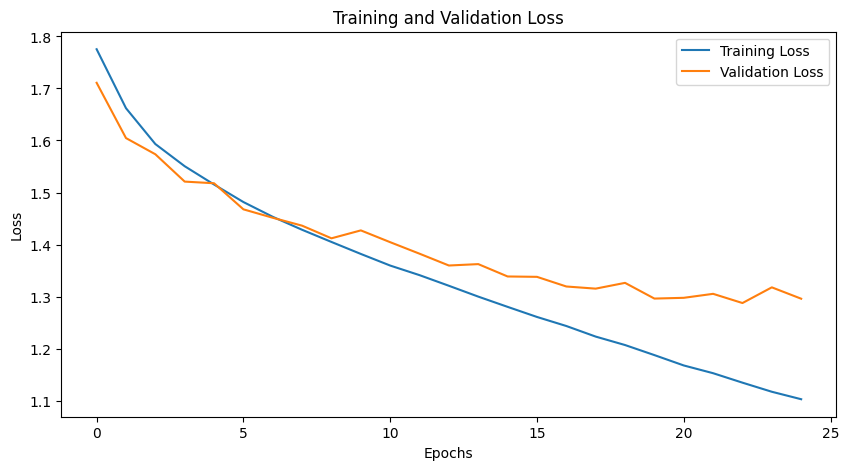

In [11]:
train_model(model1, data_loader_train, data_loader_validation, 25, 'model1', 0.0001)

c:\Users\bamdi\anaconda3\envs\PyTorch\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/25], Train Loss: 1.6494976234329835,  Validation Loss: 1.4639003213527984
Epoch [2/25], Train Loss: 1.3486523211400598,  Validation Loss: 1.364691073388125
Epoch [3/25], Train Loss: 1.1608612352861858,  Validation Loss: 1.3563335395492284
Epoch [4/25], Train Loss: 0.9692245347462678,  Validation Loss: 1.3577697224321619
Epoch [5/25], Train Loss: 0.7597249145961816,  Validation Loss: 1.4698621525173694
Epoch [6/25], Train Loss: 0.5546842314352702,  Validation Loss: 1.630148968865386
Epoch [7/25], Train Loss: 0.420731124200574,  Validation Loss: 1.8629755957991676
Epoch [8/25], Train Loss: 0.3129474793484057,  Validation Loss: 2.1035051920772654
Epoch [9/25], Train Loss: 0.25414610033925367,  Validation Loss: 2.1069558278649256
Epoch [10/25], Train Loss: 0.22184018400147193,  Validation Loss: 2.249302201566443
Epoch [11/25], Train Loss: 0.20056929559818157,  Validation Loss: 2.349508863634768
Epoch [12/25], Train Loss: 0.17910063855623815,  Validation Loss: 2.3996550150677165
Ep

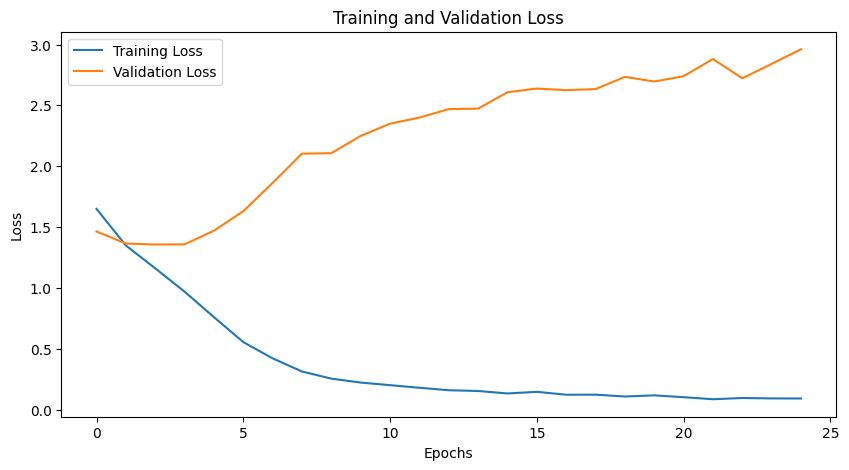

In [26]:
train_model(model_ft, data_loader_train, data_loader_validation, 25, 'model_pretrained', 0.0001)

Epoch [1/25], Train Loss: 1.8053773483614082,  Validation Loss: 1.7836286314820822
Epoch [2/25], Train Loss: 1.7547440928446423,  Validation Loss: 1.7353470019534625
Epoch [3/25], Train Loss: 1.7045256871157606,  Validation Loss: 1.6578797977582542
Epoch [4/25], Train Loss: 1.6692950979107473,  Validation Loss: 1.6498348491381756
Epoch [5/25], Train Loss: 1.6431910264199985,  Validation Loss: 1.5962867114396222
Epoch [6/25], Train Loss: 1.6212025741426346,  Validation Loss: 1.584315962496057
Epoch [7/25], Train Loss: 1.6053830171481007,  Validation Loss: 1.5784121741235784
Epoch [8/25], Train Loss: 1.5868945257169897,  Validation Loss: 1.5512845975107852
Epoch [9/25], Train Loss: 1.5715857112328036,  Validation Loss: 1.5403657687448822
Epoch [10/25], Train Loss: 1.5571053714422978,  Validation Loss: 1.5199889081769284
Epoch [11/25], Train Loss: 1.541357304577307,  Validation Loss: 1.4911769185446004
Epoch [12/25], Train Loss: 1.528436778913893,  Validation Loss: 1.476855870896736
Epoch

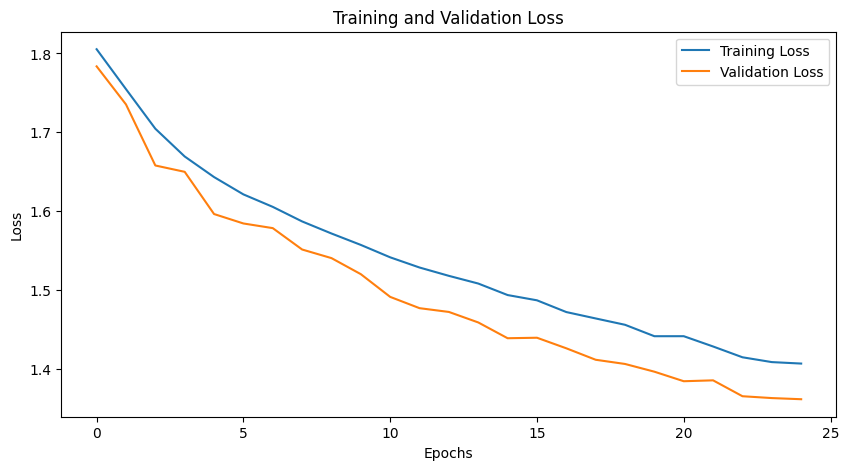

In [28]:
train_model(drp_model, data_loader_train, data_loader_validation, 25, 'drp_model', 0.0001)

Epoch [1/25], Train Loss: 1.7118625871853732,  Validation Loss: 1.59842616055919
Epoch [2/25], Train Loss: 1.5558701887693596,  Validation Loss: 1.5111146922660086
Epoch [3/25], Train Loss: 1.4705131396418956,  Validation Loss: 1.456825274281797
Epoch [4/25], Train Loss: 1.400660049809114,  Validation Loss: 1.4057806751369375
Epoch [5/25], Train Loss: 1.3442576610564123,  Validation Loss: 1.343813249495177
Epoch [6/25], Train Loss: 1.2920214975198818,  Validation Loss: 1.3314843979557003
Epoch [7/25], Train Loss: 1.2467821201927678,  Validation Loss: 1.3091243758665776
Epoch [8/25], Train Loss: 1.206820825160479,  Validation Loss: 1.2663030988347215
Epoch [9/25], Train Loss: 1.1624443049154727,  Validation Loss: 1.2702426266881217
Epoch [10/25], Train Loss: 1.123065309097082,  Validation Loss: 1.25965513064798
Epoch [11/25], Train Loss: 1.082786179265891,  Validation Loss: 1.2500140698610154
Epoch [12/25], Train Loss: 1.0405594993938583,  Validation Loss: 1.2969734404994324
Epoch [13/2

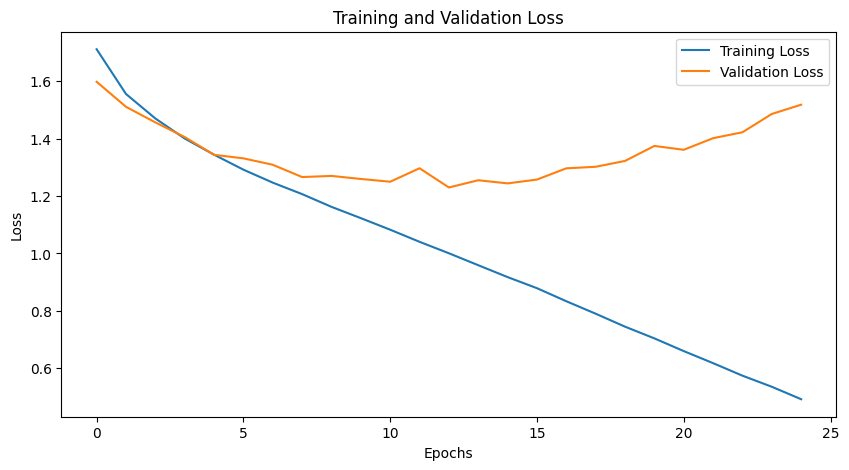

In [36]:
train_model(mr_units_model, data_loader_train, data_loader_validation, 25, 'mr_units_model', 0.0001)

Filter extraction and activation maps

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_kernels(tensor, num_cols=6, selected_channel=0):
    if not tensor.ndim == 4:
        raise Exception("Assumed input is a 4D tensor")
    
    num_kernels = tensor.shape[0]
    num_rows = (num_kernels + num_cols - 1) // num_cols
    
    # Set up a larger figure size for better readability in PDFs
    fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))  # Each subplot will have width of 2 inches and height of 2 inches
    
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)
        # Extract the filter for the selected channel
        kernel = tensor[i, selected_channel, :, :].detach().cpu().numpy()
        # Normalize the kernel to 0-1 for better visualization
        kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
        ax1.imshow(kernel, cmap='gray')
        ax1.axis('off')
        ax1.set_title(f'Filter {i+1}', fontsize=10, pad=3)  # Title with filter number, small font size for space
        
    plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust spacing to prevent overlap
    plt.show()

def visualize_filters(model, selected_channel=0):
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            # Now handles any number of channels by focusing only on the selected channel
            if layer.weight.data.shape[1] > selected_channel:
                print(f"Visualizing channel {selected_channel+1} of layer {name}")
                plot_kernels(layer.weight.data, selected_channel=selected_channel)
            else:
                print(f"Layer {name} does not have channel {selected_channel+1}. Skipped.")

# Example of how to use this function with your CNN model
# model should be your loaded or defined model


In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader

def plot_activations(t, num_cols=6):
    # t = t.cuda()
    num_kernels = t.shape[0]
    num_rows = (num_kernels + num_cols - 1) // num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        npimg = np.array(t[i].detach().cpu().numpy(), np.float32)
        npimg = (npimg - npimg.min()) / (npimg.max() - npimg.min())
        ax1.imshow(npimg, cmap="gray")
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    

def visualize_activations(model, dataloader, device):
    # Fetch a single batch from the dataloader
    images, labels = next(iter(dataloader))
    # Select the first image of the batch for visualization
    img = images[0].unsqueeze(0).to(device)  # Add batch dimension and move to device

    # We will store the activations of these layers
    activations = []
    def hook_fn(m, i, o):
        activations.append(o)

    # Assuming the model's convolutional layers are named as conv1, conv2, and conv3
    for name, layer in model.named_modules():
        # if 'conv' in name:
        if isinstance(layer, torch.nn.Conv2d):
            layer.register_forward_hook(hook_fn)

    # Forward pass
    output = model(img)

    # Plotting
    for activation in activations:
        plot_activations(activation[0])



Visualizing channel 1 of layer 0


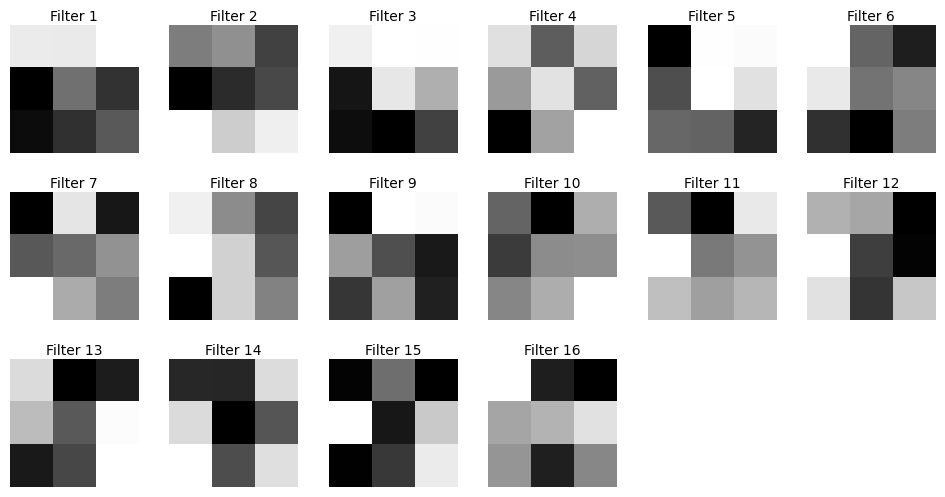

Visualizing channel 1 of layer 3


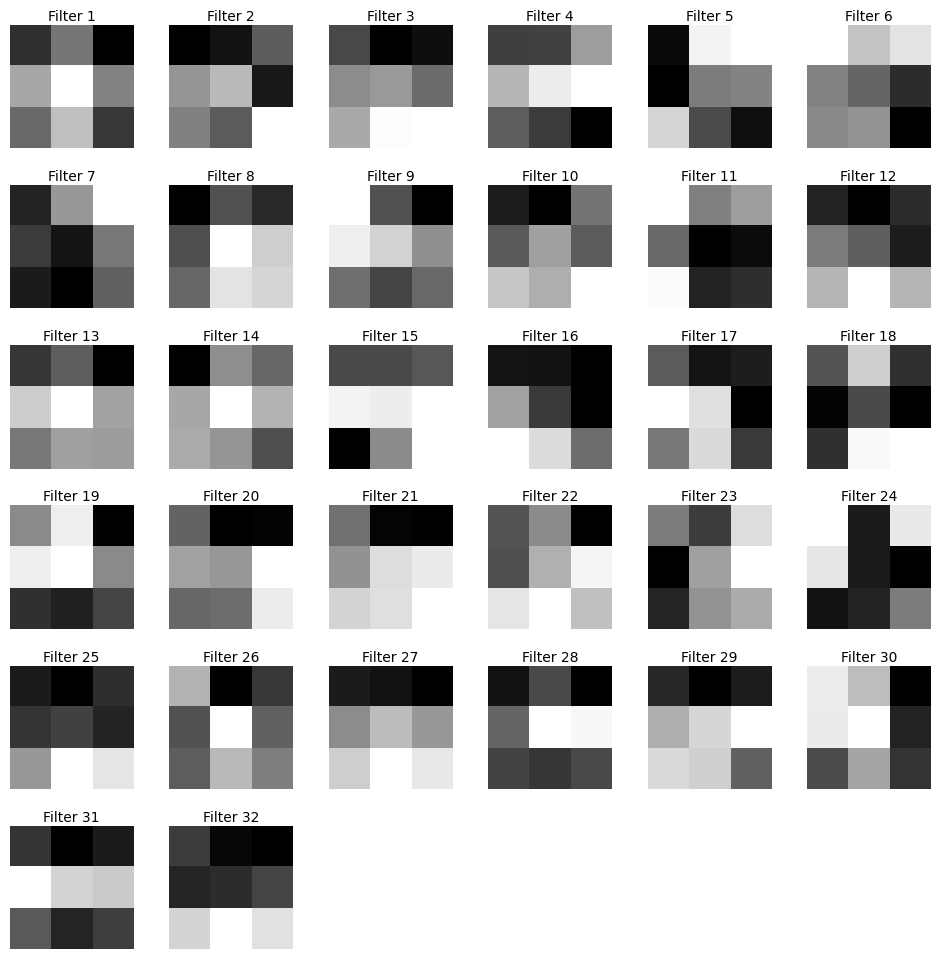

Visualizing channel 1 of layer 6


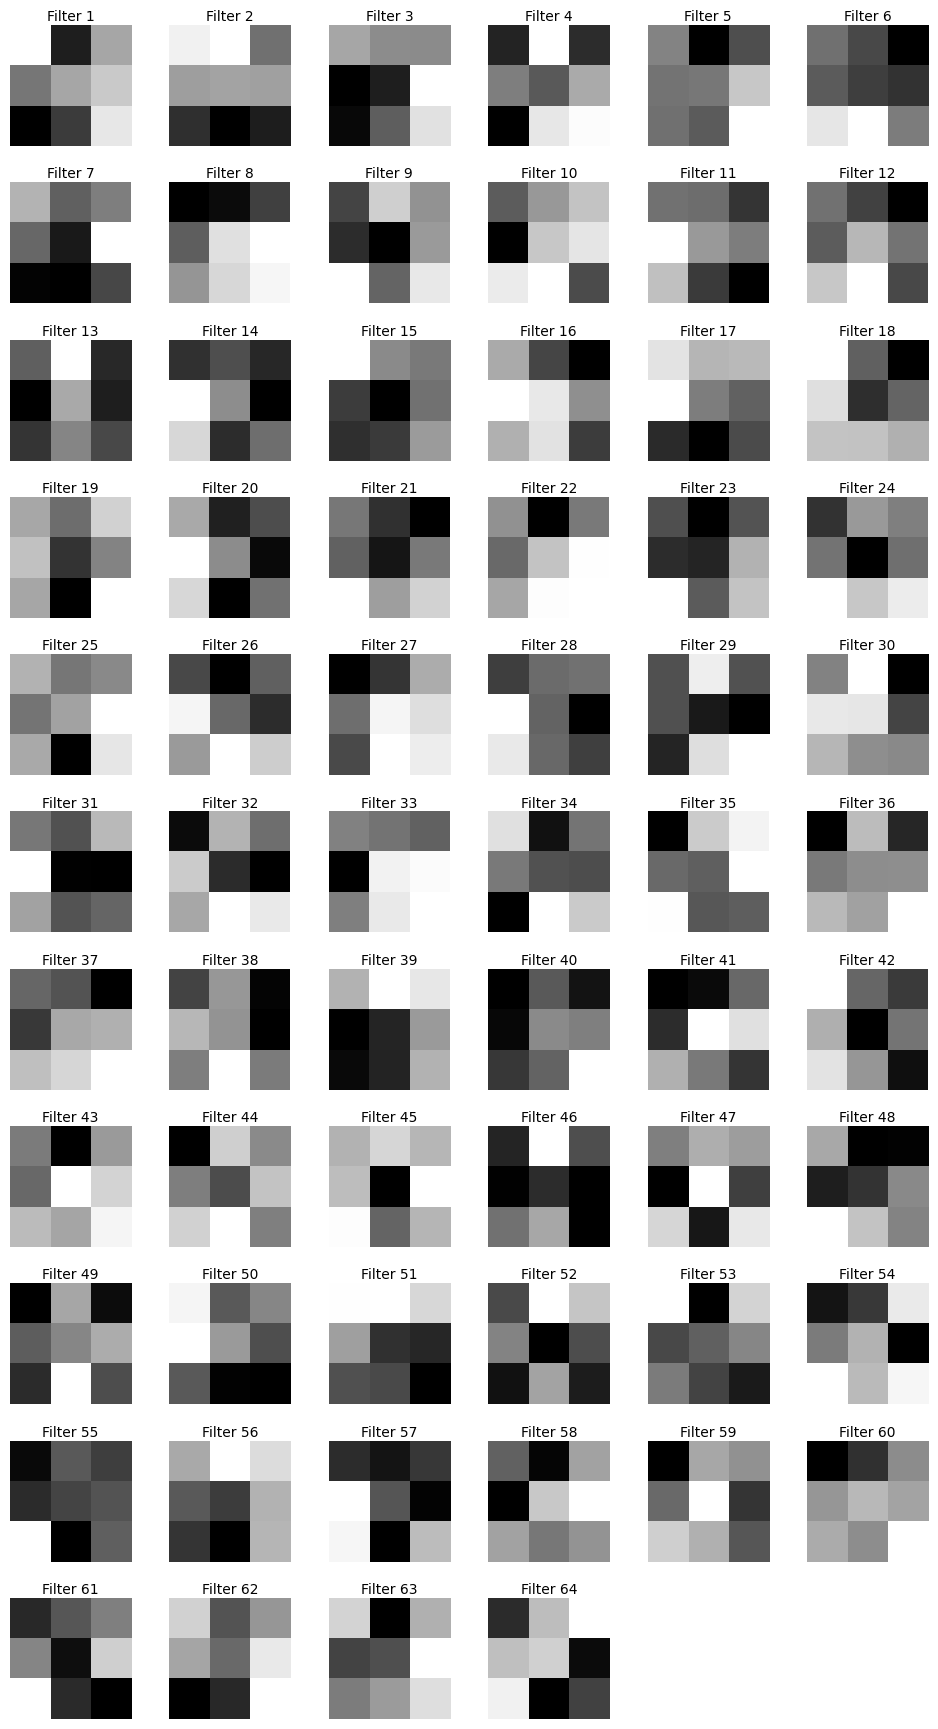

In [13]:
# create a feature map
visualize_filters(model1, selected_channel=0)

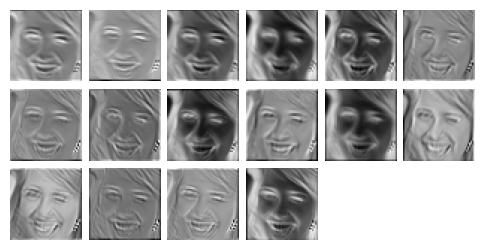

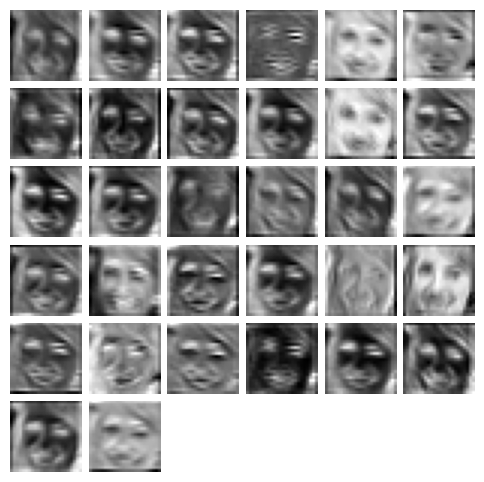

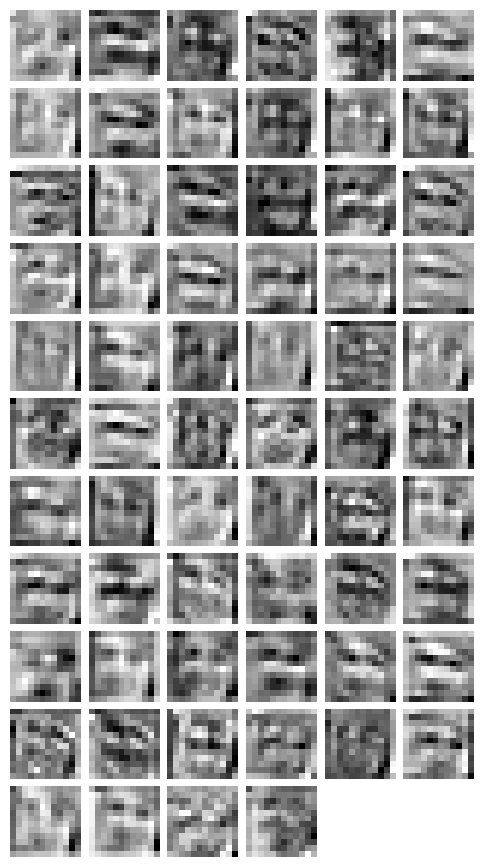

In [17]:
# Visualizing the activations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_activations(model1, data_loader_train, device)

Filters and activation for Dropout model

Visualizing channel 1 of layer 0


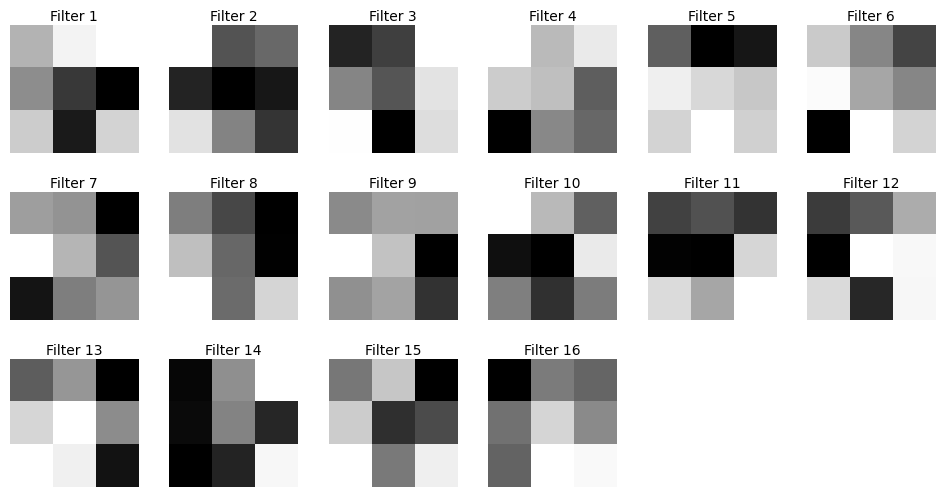

Visualizing channel 1 of layer 4


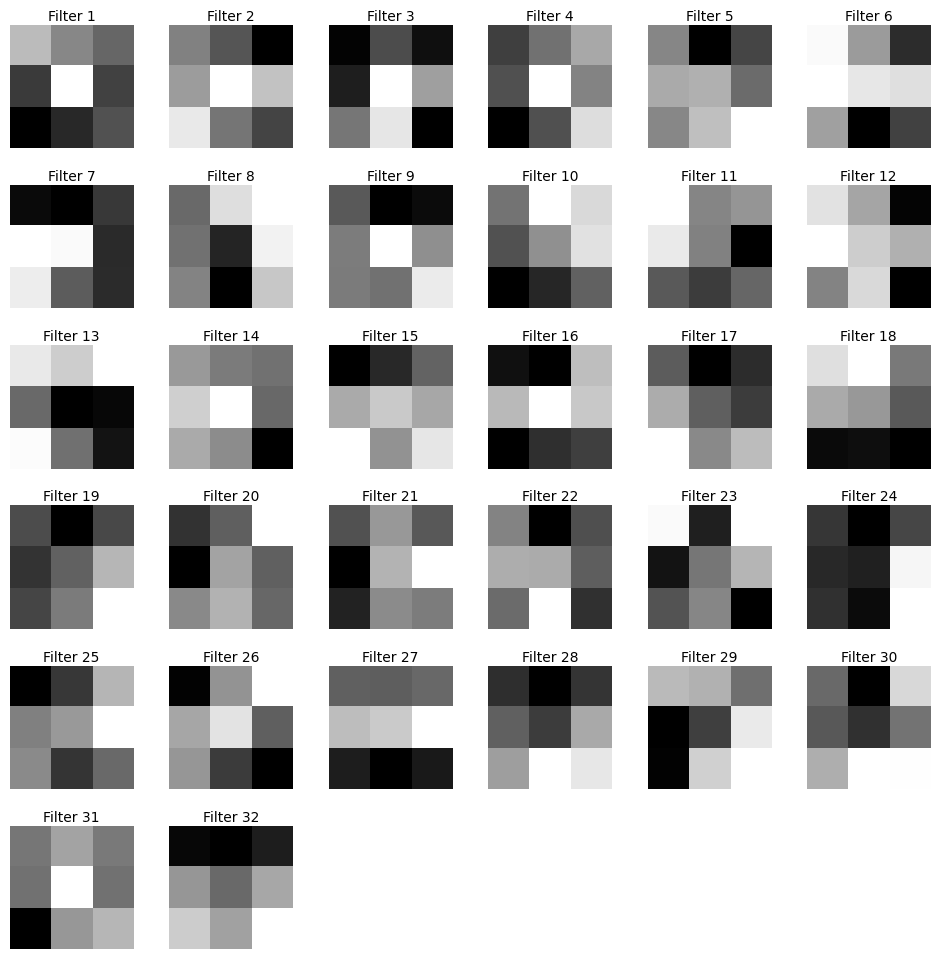

Visualizing channel 1 of layer 8


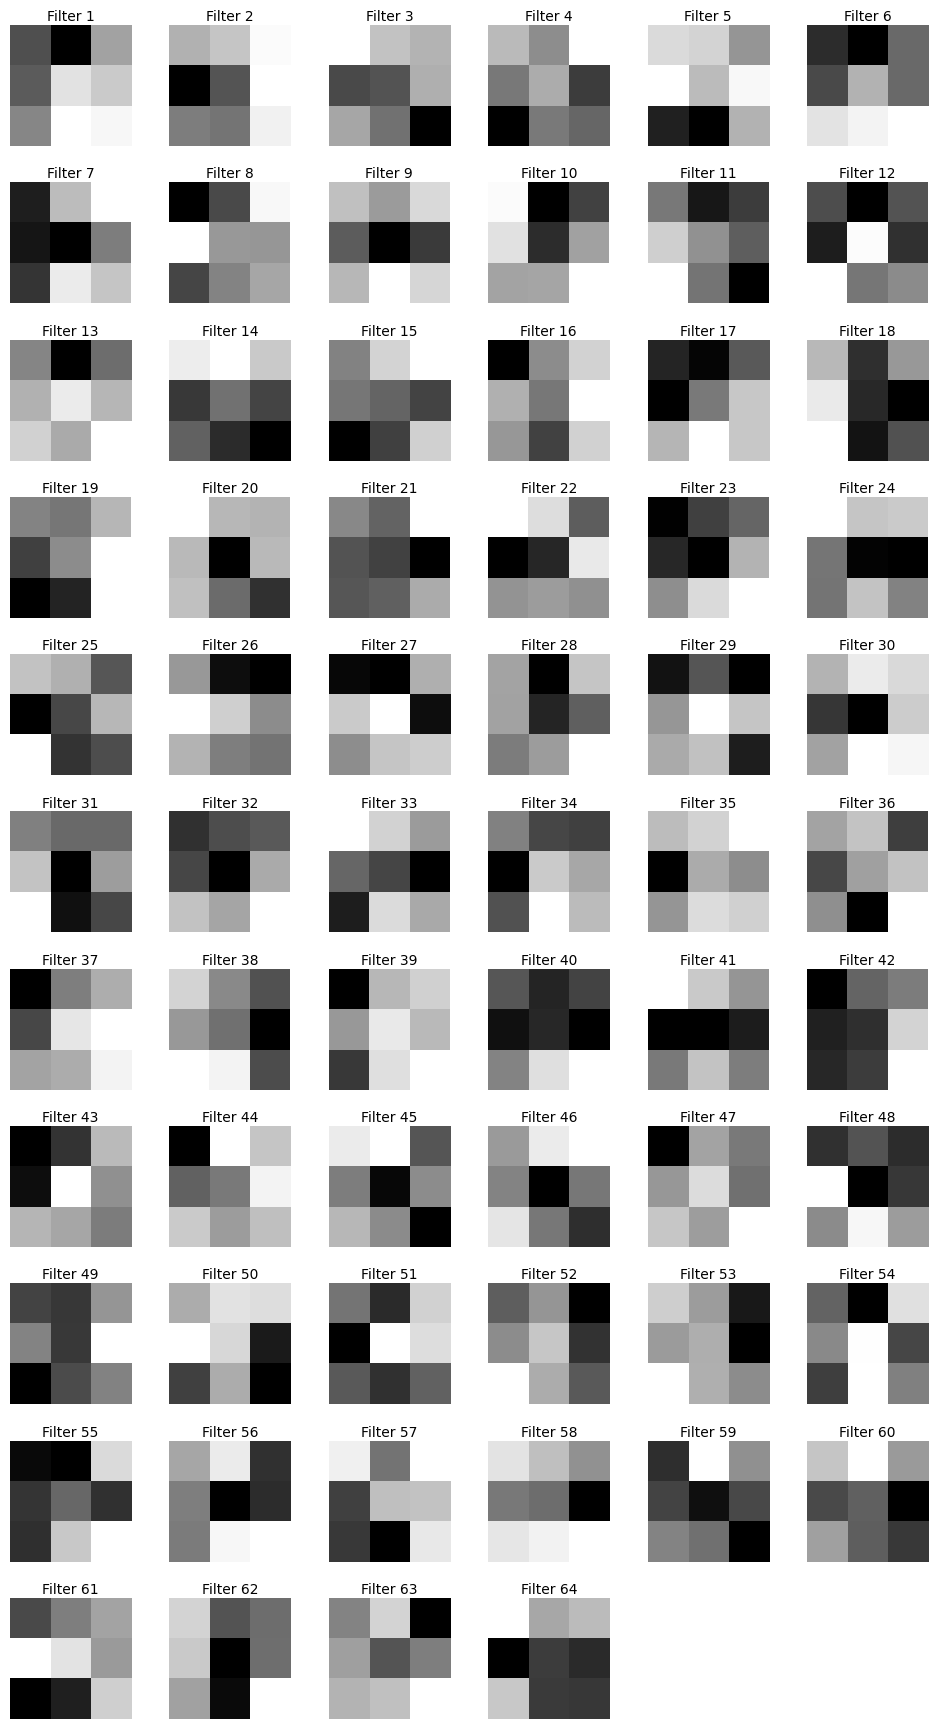

In [29]:
# create a feature map
visualize_filters(drp_model, selected_channel=0)

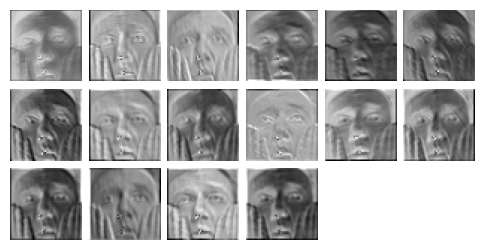

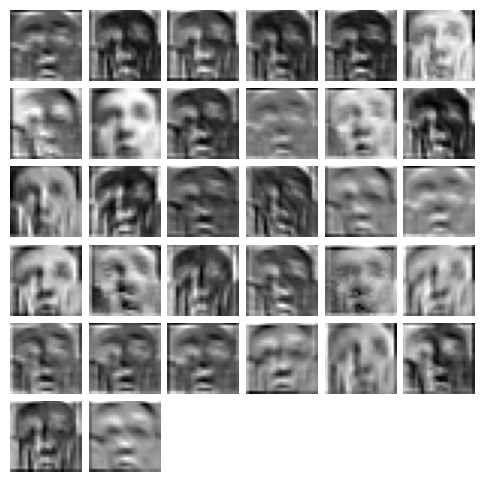

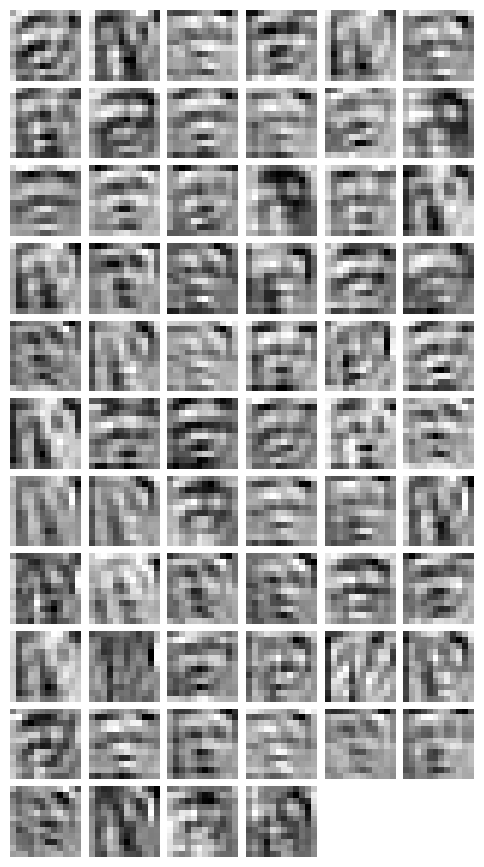

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_activations(drp_model, data_loader_train, device)

Filters and activation for model with more units 

Visualizing channel 1 of layer 0


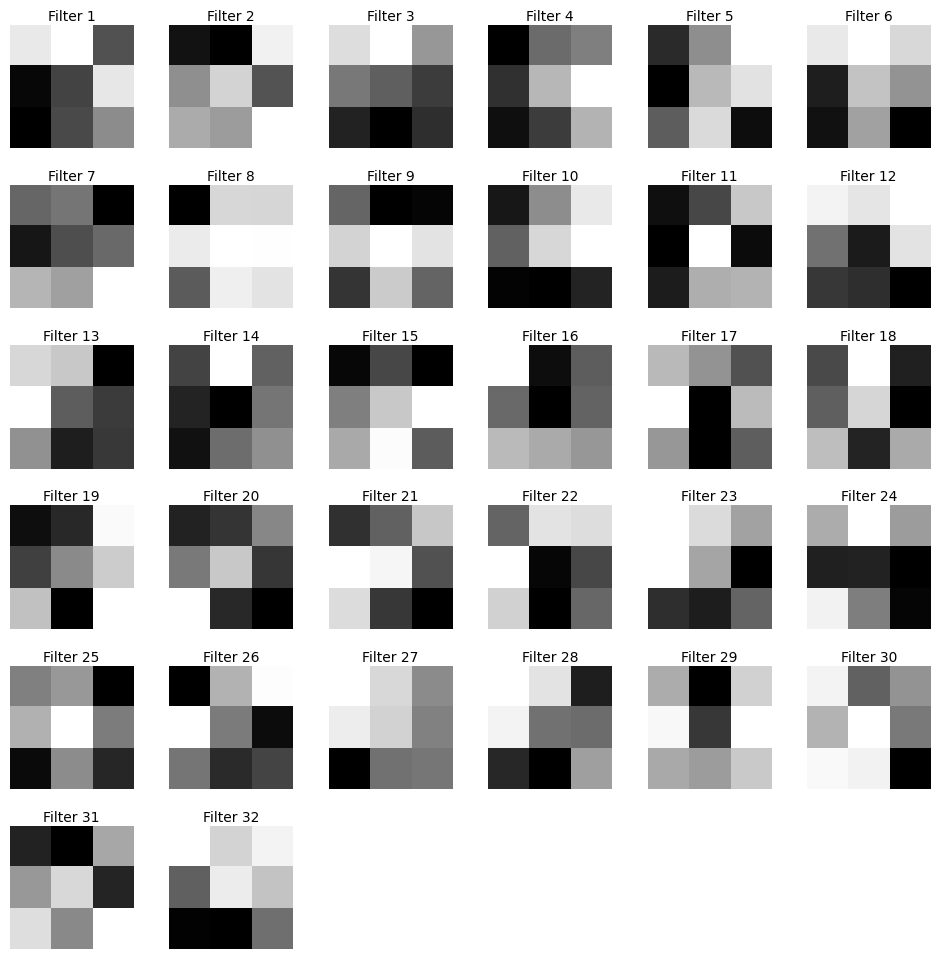

Visualizing channel 1 of layer 3


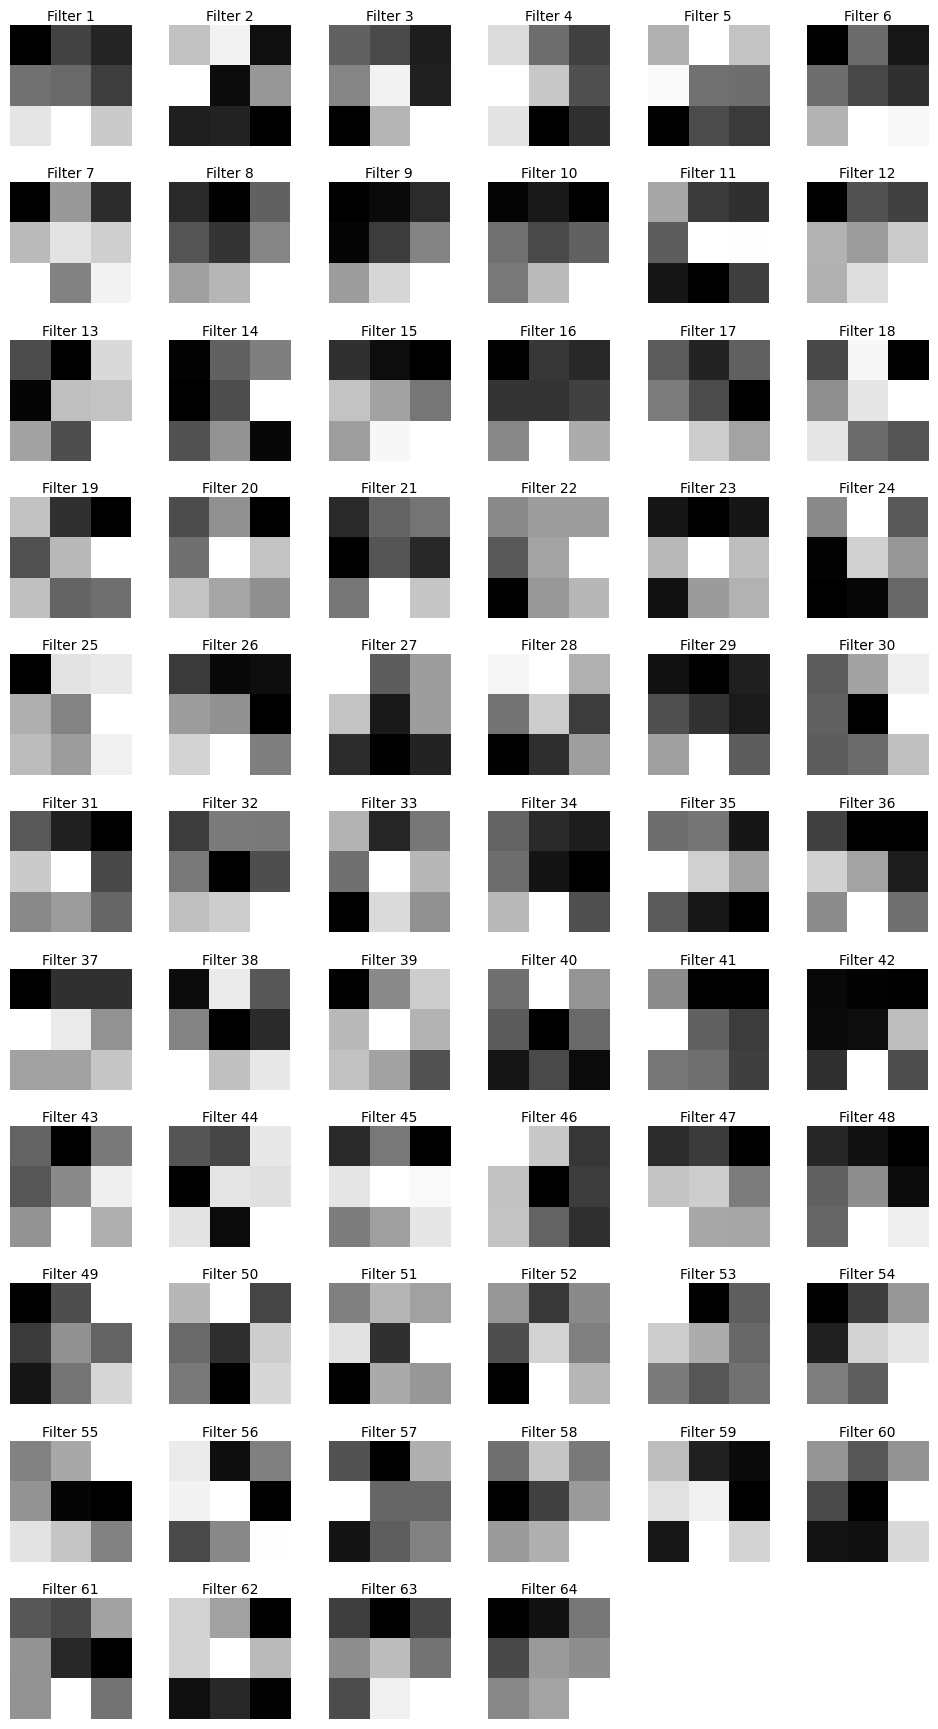

Visualizing channel 1 of layer 6


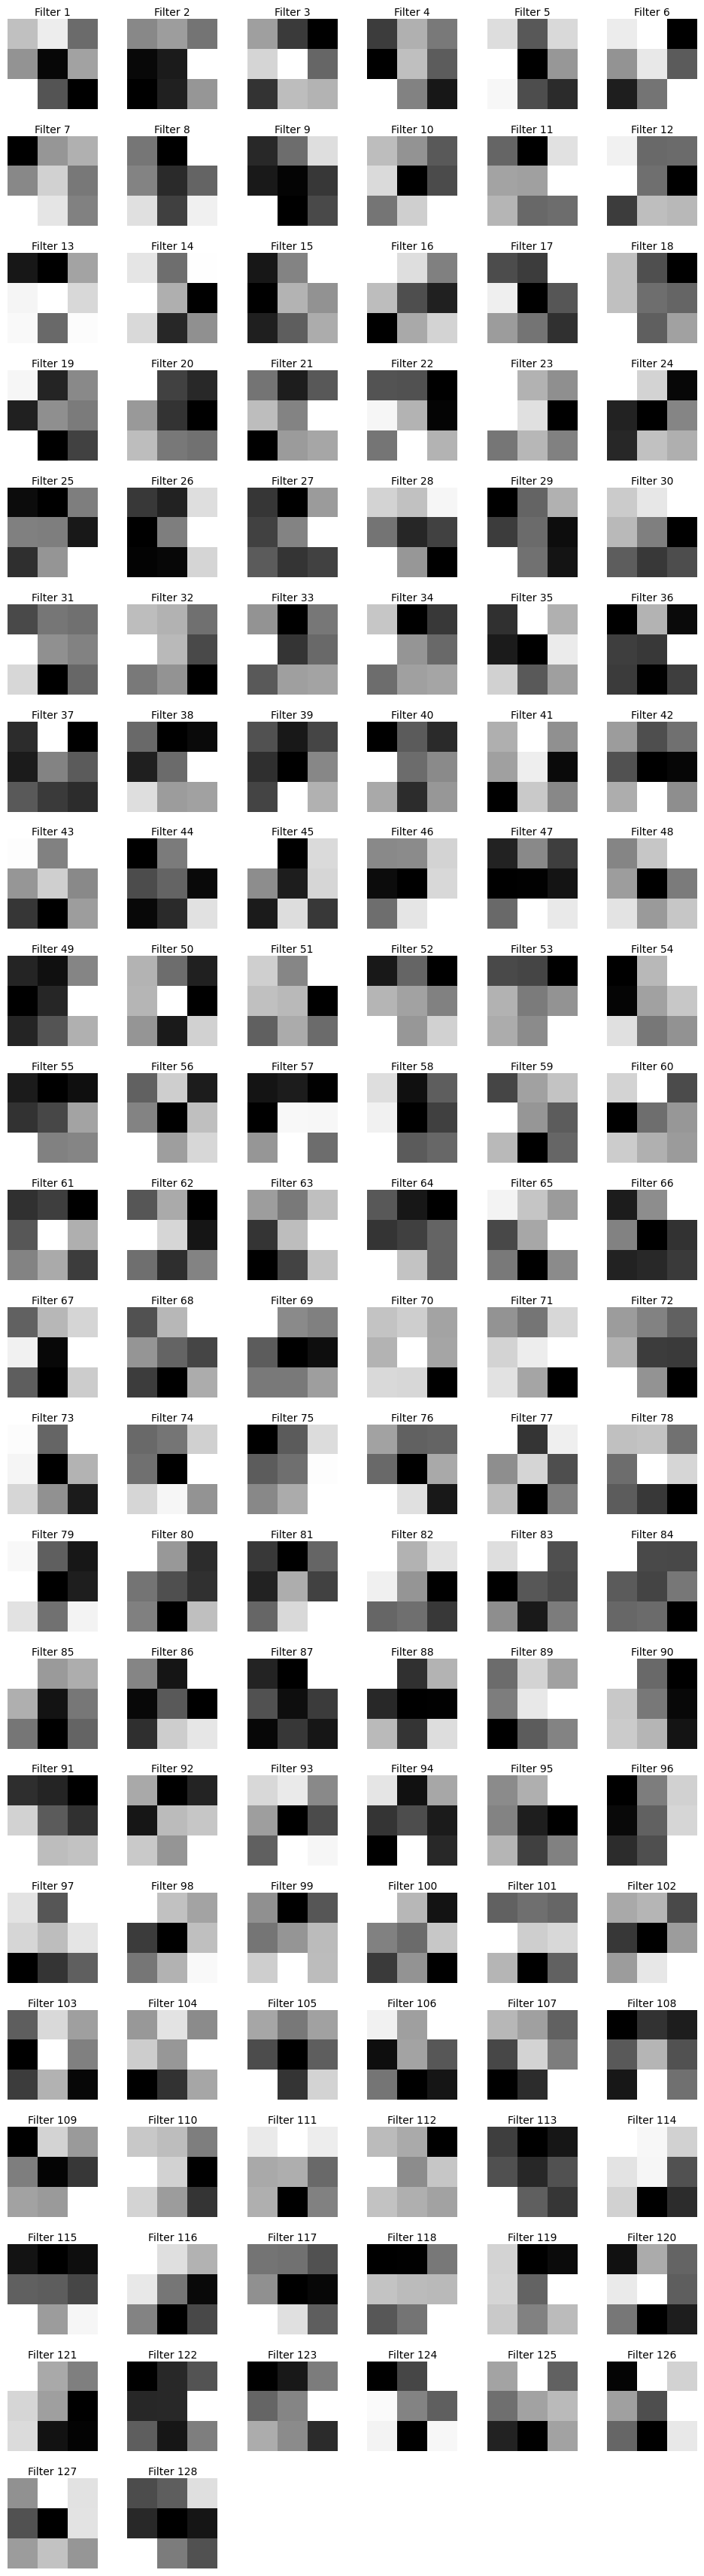

In [37]:
visualize_filters(mr_units_model, selected_channel=0)

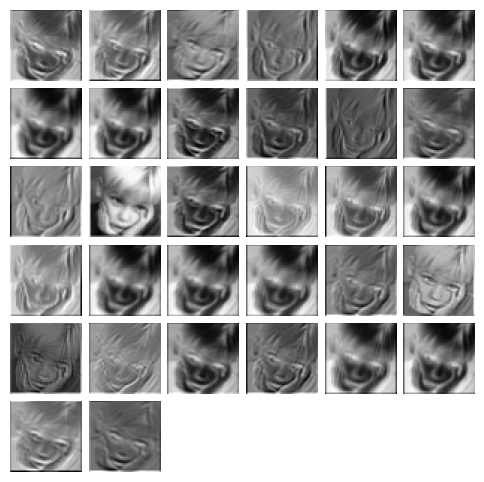

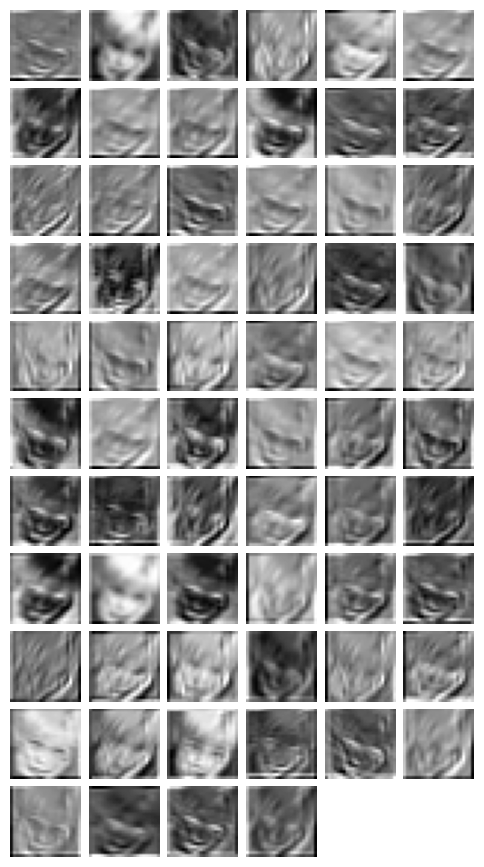

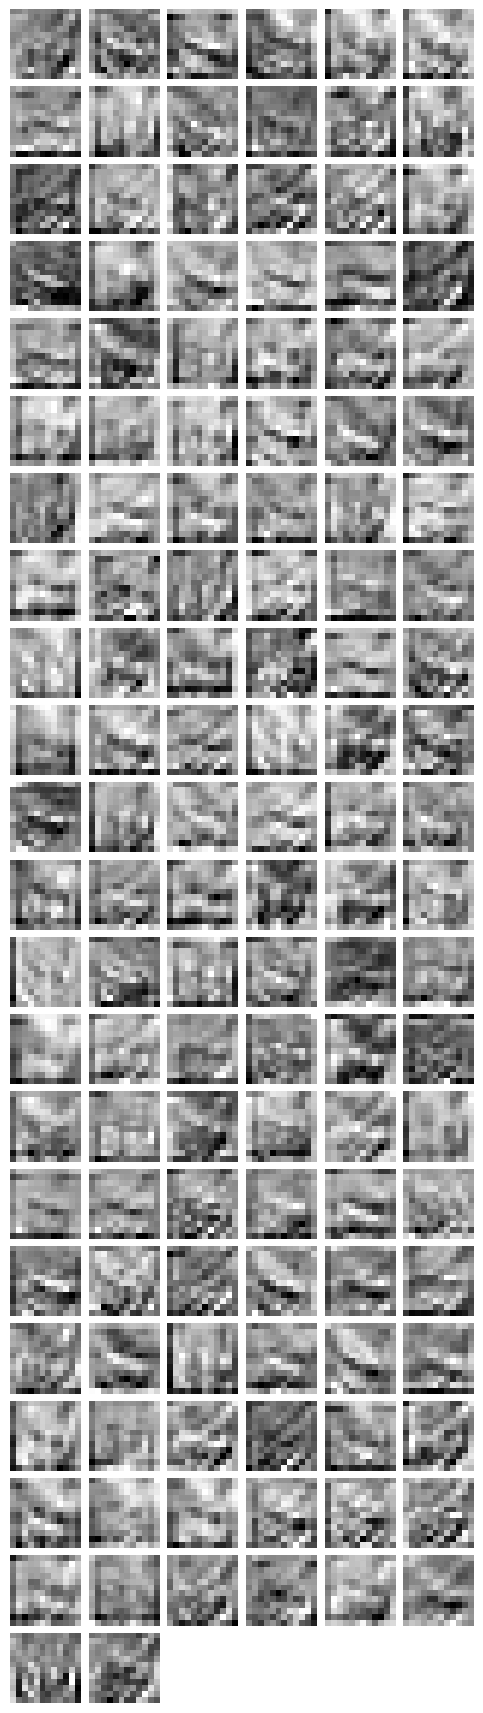

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_activations(mr_units_model, data_loader_train, device)

# Load and evaluate the model

In [18]:
model1 = Model1()
model_name = 'model1'
filename = f'{model_name}_weights.pth'
model1.load_state_dict(torch.load(filename))
model1.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=7, bias=True)
)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=7, bias=True)
)

In [19]:
# evaluate model at end of epoch
def evaluate_model(model, x_test, y_test):
    model.eval()
    y_pred = model(x_test)
    acc = 0
    count = 0
    pred_list = []
    for pred, test in zip(y_pred, y_test):
        acc += (torch.argmax(pred) == test).float()
        pred_list.append(torch.argmax(pred).detach().cpu().numpy())
        count+=1
    acc = acc/count
    pred_list = np.asarray(pred_list)
    y_pred_numpy = y_pred.detach().cpu().numpy()
    y_test_numpy = y_test.detach().cpu().numpy()
    # print(y_test) 
    # print(y_pred) 
    print(f"Accuracy is {acc}")

    # print(y_pred.shape)
    # print(Y_test.shape)
    # print(y_pred[1])
    return y_pred_numpy, y_test_numpy, pred_list


In [20]:
y_pred_numpy, y_test_numpy, pred_list = evaluate_model(model1, X_test, Y_test)

Accuracy is 0.5037615299224854
[2 6 4 ... 3 3 3]
[2 0 4 ... 3 3 3]


In [21]:
print(classification_report(y_test_numpy, pred_list))

              precision    recall  f1-score   support

           0       0.51      0.28      0.36       491
           1       0.58      0.13      0.21        55
           2       0.31      0.38      0.34       528
           3       0.66      0.77      0.71       879
           4       0.36      0.33      0.35       594
           5       0.69      0.58      0.63       416
           6       0.47      0.55      0.51       626

    accuracy                           0.50      3589
   macro avg       0.51      0.43      0.44      3589
weighted avg       0.51      0.50      0.50      3589



In [23]:
def create_confusion_matrix(y_test_numpy, pred_list):
    cm = confusion_matrix(y_test_numpy, pred_list)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(cm, annot=True, fmt='d')

    # Add titles and labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Optionally, adjust the x and y labels to match the categories if needed
    # Assuming y_test_numpy and pred_list are encoded class labels:
    # class_labels = ['Class 1', 'Class 2', 'Class 3']  # Adjust these as per your specific classes
    class_labels = ['0 (anger)','1 (disgust)','2 (fear)','3 (happiness)','4 (sadness)','5 (surprise)','6 (neutral)']

    plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation= 45)
    plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)

    # Show the plot
    plt.show()


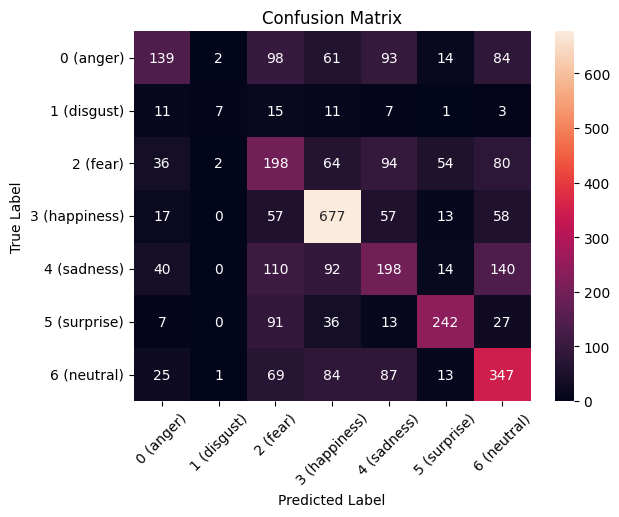

In [24]:
create_confusion_matrix(y_test_numpy, pred_list)

In [11]:
y_pred_numpy, y_test_numpy, pred_list = evaluate_model(model_ft, X_test, Y_test)
print(classification_report(y_test_numpy, pred_list))
cm = confusion_matrix(y_test_numpy, pred_list)

c:\Users\bamdi\anaconda3\envs\PyTorch\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy is 0.5867930054664612
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       491
           1       0.52      0.60      0.56        55
           2       0.48      0.43      0.45       528
           3       0.77      0.80      0.78       879
           4       0.44      0.42      0.43       594
           5       0.79      0.69      0.74       416
           6       0.51      0.58      0.54       626

    accuracy                           0.59      3589
   macro avg       0.57      0.57      0.57      3589
weighted avg       0.59      0.59      0.59      3589



Evaluation for Dropout Model

In [31]:
drp_model = Model_with_Dropout()
model_name = 'drp_model'
filename = f'{model_name}_weights.pth'
drp_model.load_state_dict(torch.load(filename))
drp_model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2304, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=128, out_features=7, bias=True)
)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2304, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=128, out_features=7, bias=True)
)

In [32]:
y_pred_numpy_drp, y_test_numpy_drp, pred_list_drp = evaluate_model(drp_model, X_test, Y_test)

Accuracy is 0.4831429719924927


In [33]:
print(classification_report(y_test_numpy_drp, pred_list_drp))

              precision    recall  f1-score   support

           0       0.40      0.31      0.35       491
           1       0.00      0.00      0.00        55
           2       0.34      0.20      0.25       528
           3       0.59      0.78      0.67       879
           4       0.35      0.30      0.33       594
           5       0.59      0.66      0.62       416
           6       0.44      0.54      0.48       626

    accuracy                           0.48      3589
   macro avg       0.39      0.40      0.39      3589
weighted avg       0.45      0.48      0.46      3589



C:\Users\bamdi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bamdi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bamdi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


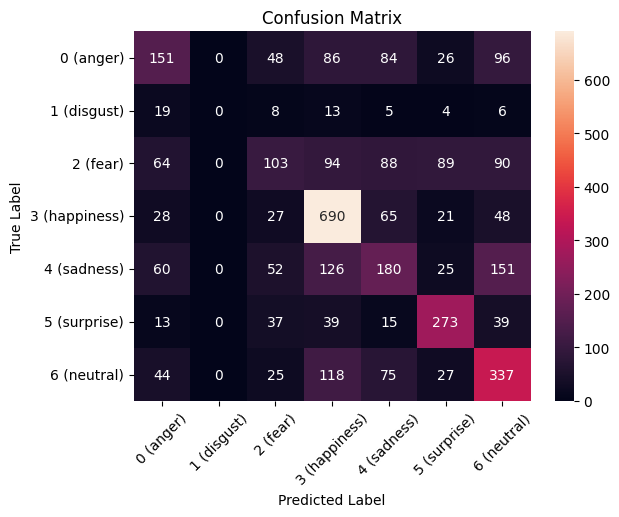

In [34]:
create_confusion_matrix(y_test_numpy_drp, pred_list_drp)

Evaluation for model with more units

In [39]:
mr_units_model = Model_with_More_Units()
model_name = 'mr_units_model'
filename = f'{model_name}_weights.pth'
mr_units_model.load_state_dict(torch.load(filename))
mr_units_model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=4608, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=7, bias=True)
)


Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=4608, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=7, bias=True)
)

In [40]:
y_pred_numpy_mr_units, y_test_numpy_mr_units, pred_list_mr_units = evaluate_model(mr_units_model, X_test, Y_test)

Accuracy is 0.5475062727928162


In [41]:
print(classification_report(y_test_numpy_mr_units, pred_list_mr_units))

              precision    recall  f1-score   support

           0       0.44      0.47      0.46       491
           1       0.48      0.58      0.53        55
           2       0.40      0.41      0.40       528
           3       0.68      0.81      0.74       879
           4       0.40      0.32      0.35       594
           5       0.71      0.66      0.68       416
           6       0.56      0.50      0.53       626

    accuracy                           0.55      3589
   macro avg       0.53      0.54      0.53      3589
weighted avg       0.54      0.55      0.54      3589



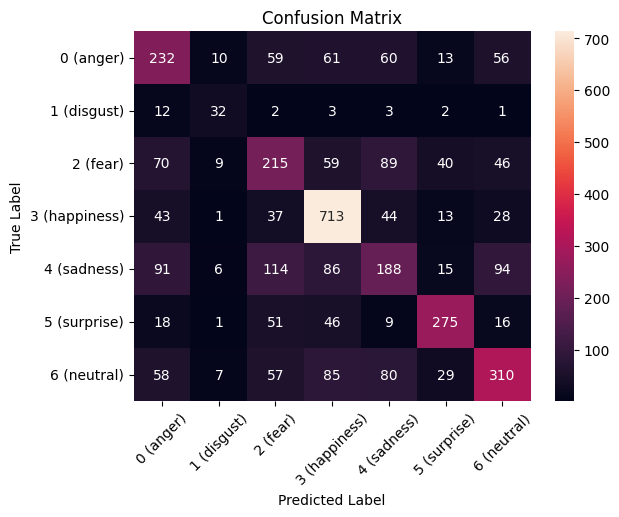

In [42]:
create_confusion_matrix(y_test_numpy_mr_units, pred_list_mr_units)